## Survival Analysis - Interferon Gamma Treatment for Chronic Granulomatous Disease (CGD)

### Motivation
Our primary interest is to see whether patients treated with interferon gamma have fewer infections than patients treated with a placebo. 

###  Background of CGD 
Chronic Granulomatous Disease (CGD) is a disorder that impairs white blood cells by mutating its protein structure which inhibits its ability to attack harmful bacteria. CGD often shows up as reoccurring infections in the form of swellings, fevers, and diarhea as a result of damaged white blood cells inability to control inflammation. Treatments include antibiotics, stimulants, and bone marrow transplants. Future treatments are looking into gene therapy that looks to repair that CGD mutations that result in that loss of protein structures leading to immunodeficiency. 

**Interferon Gamma treatment** is an injection of cytokine proteins that look to stop the spread of pathogens by interfering with their replication process, hence the name **intereferon**. Healthy white blood cells will release interferons naturally if pathogens are detected cells, however, this ability is inhibited by CGD. Clinicians will often inject interferon gamma in immunocompromised patients to reduce their severity of serious infections. 

### What is Survival Analysis?
Survival analysis is used to analyze data in which **time to the event** is the focus of interest where the response variable is either event time or survival time. The original purpose has its morbid roots in the medical field where clinicians were interested in predicting the survival probabilities of patients with a particular disease based on their individual features/covariates. Domains outside the clinical field have applied survival analysis to problems such as customer churn prediction, bank loan survival, credit risk, etc. 

### Survival Function $S(t)$
A primary objective of survival analysis is to estimate the **survival curve** (or survival function) that quantifies the probability of survival as a function of time. The survival function is defined as the probability of an observation surviving up until time t where T is a random variable of survival time.

$$
S(t)=P(T>t)
$$

### The Dataset
The .dat file was provided by the University of Newcastle.
* Subject ID: 128 subjects
* Center: Medical center (14)
* Randomization date (Month/Day/Year)
* Treatment: {0: placebo, 1: gamma interferon}
* Sex: {1: Male, 2: Female}
* Age: Age (years) at entry of study
* HeightCm: Height (cm) at entry of study
* WeightKg: Weight (kg) at entry of study
* Pattern Inheritance: {1: X-linked, 2: Autosomal recessive}
* Corticosteroids Use: {1: used, 2: did not use}
* Antibioitic Use: {1: used, 2: did not use}
* Institution: {1: US NIH, 2: US Other, 3: Europe Amsterdam, 4: Europe Other}
* Time to Follow-Up: Time from randomization to last follow-up (days)
* Time1-Time7: Time from randomization until infection (multiple infections recorded)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index as cindex
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
random_seed = 1

### Load data from .dat file

In [3]:
df = pd.read_stata('gi_gcd.dta')

### Initial Data Exploration

In [4]:
df.head()

,id,center,randomisationdate,treatment,sex,age,heightcm,weightkg,patterninheritance,corticosteroiduse,antibioticuse,institution,timetofollowup,time1,time2,time3,time4,time5,time6,time7
0,1,204,82888,1,2,12,147.0,62.000000,2,2,2,2,414,219.0,373.0,NaN,NaN,NaN,NaN,NaN
1,2,204,82888,0,1,15,159.0,47.500000,2,2,1,2,439,8.0,26.0,152.0,241.0,249.0,322.0,350.0
2,3,204,82988,1,1,19,171.0,72.699997,1,2,1,2,382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,204,91388,1,1,12,142.0,34.000000,1,2,1,2,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,238,92888,0,1,17,162.5,52.700001,1,2,1,1,383,246.0,253.0,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(128, 20)

In [6]:
df.columns

Index(['id', 'center', 'randomisationdate', 'treatment', 'sex', 'age',
       'heightcm', 'weightkg', 'patterninheritance', 'corticosteroiduse',
       'antibioticuse', 'institution', 'timetofollowup', 'time1', 'time2',
       'time3', 'time4', 'time5', 'time6', 'time7'],
      dtype='object')

#### Count Infection Numbers in Patients
* 0: No infections
* 1: Infections

In [7]:
infection = []
for value in df.iloc[:, -7:].sum(axis=1):
    if value != 0.0:
        infection.append(1)
    else:
        infection.append(0)

df['infection'] = infection

In [8]:
df.iloc[:,-8:].sample(5)

,time1,time2,time3,time4,time5,time6,time7,infection
77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
89,14.0,NaN,NaN,NaN,NaN,NaN,NaN,1
69,236.0,NaN,NaN,NaN,NaN,NaN,NaN,1
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [9]:
df['infection'].value_counts()

0    84
1    44
Name: infection, dtype: int64

In [10]:
df['infection'].value_counts(1)

0    0.65625
1    0.34375
Name: infection, dtype: float64

#### Calculate Number of Infections per Patient

In [11]:
#Calculate number of infections per patient
df['num_infections'] = df.iloc[:,-8:-1].notnull().sum(axis=1)

In [12]:
df[df['infection']==1]['num_infections'].value_counts()

1    27
2     9
3     5
7     1
5     1
4     1
Name: num_infections, dtype: int64

In [13]:
#Calculate % of infected patients who experienced more than 1 infection
df[df['infection']==1]['num_infections'].value_counts(1)[1:].sum()

0.3863636363636363

#### Sample Size for Each Treatment Arm

In [14]:
#Count number of patients in treatment and control arm
#0: Placebo group, 1: Interferon Gamma treatment
df['treatment'].value_counts()

0    65
1    63
Name: treatment, dtype: int64

### Data Visualization
* Distribution plots for continuous variables
* Count plots for categorical variables stratafied by treatment group

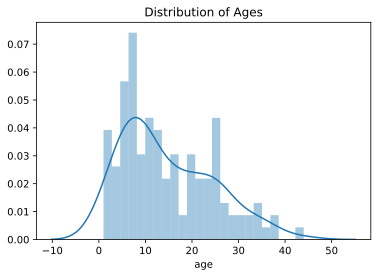

In [15]:
sns.distplot(df['age'], bins=24)
plt.title('Distribution of Ages')
plt.show()

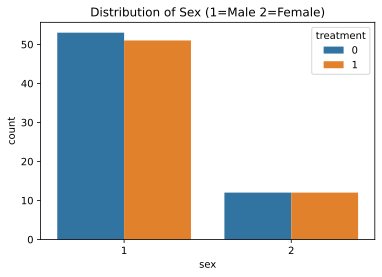

In [16]:
sns.countplot(df['sex'], hue=df['treatment'])
plt.title('Distribution of Sex (1=Male 2=Female)')
plt.show()

In [17]:
df['sex'].value_counts()

1    104
2     24
Name: sex, dtype: int64

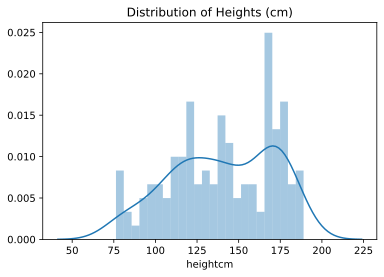

In [18]:
sns.distplot(df['heightcm'], bins=24)
plt.title('Distribution of Heights (cm)')
plt.show()

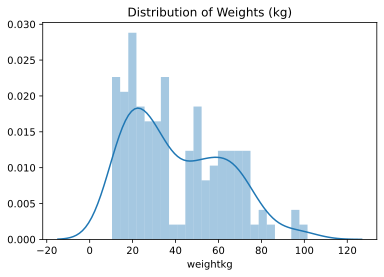

In [19]:
sns.distplot(df['weightkg'], bins=24)
plt.title('Distribution of Weights (kg)')
plt.show()

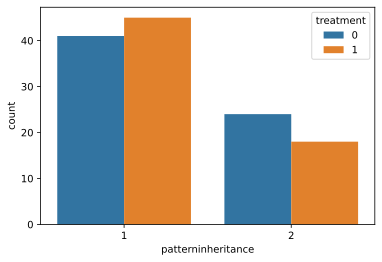

In [20]:
sns.countplot(df['patterninheritance'], hue=df['treatment'])
plt.show()

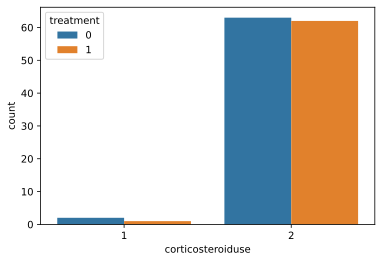

In [21]:
sns.countplot(df['corticosteroiduse'], hue=df['treatment'])
plt.show()

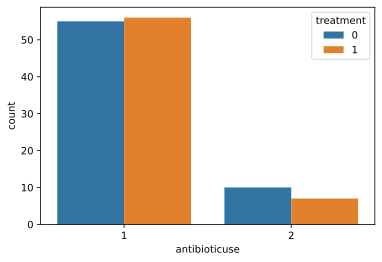

In [22]:
sns.countplot(df['antibioticuse'], hue=df['treatment'])
plt.show()

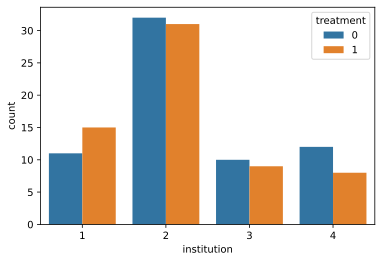

In [23]:
sns.countplot(df['institution'], hue=df['treatment'])
plt.show()

### Generate Time Variable
* Time to final follow-up for patients who did not get an infection.
* Time to first infection for patients who did get an infection.

In [24]:
df.sample(3)

,id,center,randomisationdate,treatment,sex,age,heightcm,weightkg,patterninheritance,corticosteroiduse,...,timetofollowup,time1,time2,time3,time4,time5,time6,time7,infection,num_infections
57,58,332,120988,0,1,32,185.0,95.000000,2,2,...,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12,13,238,101088,1,1,12,144.0,36.900002,1,2,...,388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
44,45,238,113088,1,2,9,140.0,36.000000,2,2,...,339,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [25]:
def time_gen(x):
    if x['infection'] == 1:
        return x['time1']
    else:
        return x['timetofollowup']
    
df['time'] = df.apply(lambda x: time_gen(x), axis=1)

In [26]:
#Check our lambda function works
df[['timetofollowup', 'time1', 'infection', 'time']].sample(3)

,timetofollowup,time1,infection,time
3,388,NaN,0,388.0
62,322,226.0,1,226.0
80,276,NaN,0,276.0


### Kaplan-Meier Survival Estimates
The **Kaplan-Meier Product-Limit Method** is a non-parametric technique used for estimating the survival function. The idea is that if we have survival times for $n$ individuals and $r$ of these survival times are larger than a specified time $t$, then the probability of surviving more than $t$ units of time would simply be ${\dfrac{r}{n}}$.

$$
S(t)=P(T>t)= {\dfrac{r}{n}}
$$

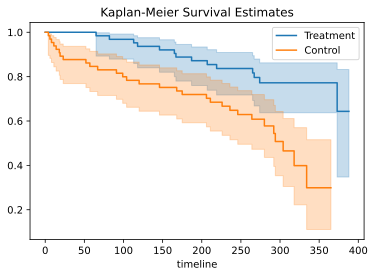

In [27]:
from lifelines import KaplanMeierFitter

trt = df['treatment'] == 1

kmf = KaplanMeierFitter()
kmf.fit(df[trt]['time'], df[trt]['infection'], label='Treatment')
kmf.plot()

kmf.fit(df[~trt]['time'], df[~trt]['infection'], label='Control')
kmf.plot()
plt.title('Kaplan-Meier Survival Estimates')
plt.show()

* It is clear from looking at the Kaplan-Meier curves that the treatment with interferon gamma is associated with a lower rate of infections than the placebo. We can compare the difference statistically with the log-rank test.

### Log-Rank Test for Comparison Between Groups
The Log-Rank test is a statistical method that can be used to detect the differences between survival curves of two different groups, typically treatment versus control groups. 

The mortality rate can be described in the hazard function $h(t)$ conditioned on the survival until time $t$ where compare the hazard functions of both groups by computing a **hazard ratio**. 

$$
h(T)= {\dfrac{-S'(t)}{S(t)}}
$$

A constant hazard ratio of Ψ units means that if an individual survived for $t$ units, the chance of experiencing the event follow $t$ is Ψ times greater in one group pthan in the other group, and the same for all values of $t$. 

The null hypothesis for the log-rank test is:

$$
H_0: Ψ = 1
$$

stating that there is no difference in survival experience between the two groups.

The idea is that it is a chi-squared test that compares the observed and expected number of deaths in each time interval of the study. One major assumption is the **proportional hazards assumption** in that the ratio of the two mortality rates of each group are constant over time. 

$$
χ^2= {\dfrac{(O_1 - E_1 )^2}{E_1}} + {\dfrac{(O_2 - E_2 )^2}{E_2}}
$$

A significant log-rank test statistic $(p<0.05)$ suggests that there the difference in the survivability between the two groups is statistically significant, and that we have enough evidence to reject $H_0$. 

In [28]:
#Number of patients experiencing infections in the control group
df[~trt]['infection'].sum()

30

In [29]:
#Number of patients experiencing infections in the treatment group
df[trt]['infection'].sum()

14

In [30]:
from lifelines.statistics import logrank_test

results = logrank_test(df[trt]['time'], df[~trt]['time'], 
                       df[trt]['infection'], df[~trt]['infection'])

results.print_summary()

Given that there were 30 infections in the control group and only 14 infections in the treatment group, the log-rank test indicated that the difference in infection hazard between the two groups was **statistically significant** (p < 0.005). The treatment with interferon gamma was associated with a lower hazard of infection compared to placebo.

### Data Pre-Processing

In [31]:
df.columns

Index(['id', 'center', 'randomisationdate', 'treatment', 'sex', 'age',
       'heightcm', 'weightkg', 'patterninheritance', 'corticosteroiduse',
       'antibioticuse', 'institution', 'timetofollowup', 'time1', 'time2',
       'time3', 'time4', 'time5', 'time6', 'time7', 'infection',
       'num_infections', 'time'],
      dtype='object')

In [32]:
df['age'] = np.log(df['age']) # log transform age column
df['weightkg'] = np.log(df['weightkg'])
df.drop(['id', 'randomisationdate', 'timetofollowup', 'time1','time2','time3',
         'time4','time5','time6','time7','num_infections'], axis=1, inplace=True)

#### Re-encode features

In [33]:
#Re-encode 1/2 to 0/1
df['sex'] = df['sex'].apply(lambda x: 0 if x==1 else 1)
df['patterninheritance'] = df['patterninheritance'].apply(lambda x: 0 if x==1 else 1)
df['corticosteroiduse'] = df['corticosteroiduse'].apply(lambda x: 0 if x==1 else 1)
df['antibioticuse'] = df['antibioticuse'].apply(lambda x: 0 if x==1 else 1)

#### Dummy Encode Categorical Variables

In [34]:
#Dummy Encode Categorical Variables
cat_columns = ['center', 'institution']
onehot_df = pd.get_dummies(df, columns= cat_columns, drop_first=False)

#### Split Data

In [35]:
np.random.seed(random_seed)
df_train, df_test = train_test_split(onehot_df, test_size = 0.25)

#### Normalize Continuous Features
* Use training set mean and standard deviation

In [36]:
#Normalization
continuous_columns = ['age', 'heightcm', 'weightkg']
train_mean = df_train.loc[:, continuous_columns].mean()
train_std = df_train.loc[:, continuous_columns].std()

In [37]:
df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - train_mean) / train_std
df_test.loc[:, continuous_columns] = (df_test.loc[:, continuous_columns] - train_mean) / train_std

### Cox Proportional Hazards Model (Cox Regression)
The Cox PH model is a semi-parametric regression model used to model survival data when several covariates of interests are being investigated for their effect on survivability.

$$
h(t) = h_0(t) * e^{β_1X_1 + β_2X_2 + ... + β_kX_k}
$$

* $h_0(t)$ represents the baseline hazard where all covariates equal 0
* $h(t)$ represents the hazard function

#### Performance Metric

I will be using the **Harrell's Concordance Index (c-index)** to evaluate model performances. The c-index is a concordant statistic where the idea is that a patient with a shorter time to event (eg. faster time to death) should have a higher risk score than a patient with a longer time to event (eg. slower time to death).

In [38]:
#Full model
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_train, duration_col='time', event_col='infection', step_size=0.1)

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>

In [39]:
cph.check_assumptions(df_train)

Proportional hazard assumption looks okay.


In [40]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>
             duration col = 'time'
                event col = 'infection'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 96
number of events observed = 34
   partial log-likelihood = -130.14
         time fit was run = 2020-12-13 02:32:01 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
treatment           -0.90       0.41       0.34            -1.56            -0.24                 0.21                 0.78
sex                 -0.46       0.63       0.48            -1.40             0.47                 0.25                 1.61
age                 -0.17       0.85       0.24            -0.64             0.31                 0.53                 1.36
heightcm            -0.01       0.99       0.26            -0.53             0.50                 0.59                 1.66
weightkg             0.10       1.10       0.26            -0.41             0.60                 0.66                 1.83
patterninheritance   0.50       1.64       0.41            -0.31             1.31                 0.73                 3.70
corticosteroiduse   -1.58       0.21       1.23            -3.98             0.83                 0.02                 2.29
antibioticuse        0.20       1.23       0.50            -0.78             1.19                 0.46                 3.29
center_174          -1.16       0.31       2.17            -5.42             3.09                 0.00                21.92
center_204           0.49       1.63       0.57            -0.63             1.60                 0.53                 4.97
center_222          -0.93       0.39       1.67            -4.20             2.33                 0.02                10.31
center_238           0.05       1.05       0.63            -1.19             1.29                 0.30                 3.62
center_242           0.44       1.55       0.77            -1.08             1.95                 0.34                 7.01
center_243           0.37       1.44       0.65            -0.90             1.64                 0.41                 5.14
center_245          -0.38       0.69       0.90            -2.15             1.39                 0.12                 4.03
center_248          -0.78       0.46       1.25            -3.22             1.66                 0.04                 5.25
center_249          -0.12       0.89       0.78            -1.65             1.41                 0.19                 4.11
center_328           0.10       1.10       0.75            -1.38             1.58                 0.25                 4.84
center_331           0.18       1.20       0.76            -1.30             1.66                 0.27                 5.27
center_332          -0.28       0.75       0.73            -1.72             1.15                 0.18                 3.17
center_336          -0.30       0.74       0.92            -2.10             1.49                 0.12                 4.45
institution_1        0.05       1.05       0.63            -1.19             1.29                 0.30                 3.62
institution_2        0.14       1.15       0.53            -0.90             1.18                 0.41                 3.26
institution_3       -0.28       0.75       0.73            -1.72             1.15                 0.18                 3.17
institution_4       -0.07       0.94       0.73            -1.50             1.37                 0.22                 3.94
                       z    p   -log2(p)
covariate                               
treatment          -2.68 0.01       7.10
sex                -0.97 0.33       1.58
age                -0.68 0.49       1.02
heightcm           -0.04 0

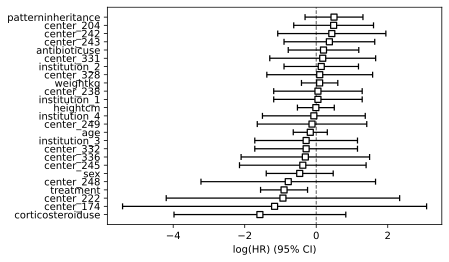

In [41]:
cph.plot()
plt.show()

In [42]:
cph_train = cph.score(df_train, scoring_method='concordance_index')
cph_test = cph.score(df_test, scoring_method='concordance_index')

In [43]:
print('Full CPH Model')
print('Training Score: ', cph_train)
print('Testing Score: ', cph_test)

Full CPH Model
Training Score:  0.7414935925762263
Testing Score:  0.6215139442231076


### CPH Model w/o Height and Weight Columns

In [44]:
df_train.columns

Index(['treatment', 'sex', 'age', 'heightcm', 'weightkg', 'patterninheritance',
       'corticosteroiduse', 'antibioticuse', 'infection', 'time', 'center_174',
       'center_204', 'center_222', 'center_238', 'center_242', 'center_243',
       'center_245', 'center_248', 'center_249', 'center_328', 'center_331',
       'center_332', 'center_336', 'institution_1', 'institution_2',
       'institution_3', 'institution_4'],
      dtype='object')

In [45]:
#Drop height and weight columns
columns = ['time', 'infection','treatment', 'sex', 'age',
           'patterninheritance', 'antibioticuse',
           'center_204', 'center_222', 'center_238', 'center_242',
           'center_243', 'center_245', 'center_248', 'center_249', 'center_328',
           'center_331', 'center_332', 'center_336', 
           'institution_2','institution_3', 'institution_4']

cph2 = CoxPHFitter(penalizer=0.1)
cph2.fit(df_train[columns], duration_col='time', event_col='infection')

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>

In [46]:
cph2.check_assumptions(df_train[columns])

Proportional hazard assumption looks okay.


In [47]:
cph2.print_summary()

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>
             duration col = 'time'
                event col = 'infection'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 96
number of events observed = 34
   partial log-likelihood = -131.06
         time fit was run = 2020-12-13 02:32:03 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
treatment           -0.91       0.40       0.33            -1.56            -0.25                 0.21                 0.78
sex                 -0.37       0.69       0.46            -1.28             0.54                 0.28                 1.72
age                 -0.11       0.90       0.18            -0.45             0.24                 0.63                 1.27
patterninheritance   0.52       1.68       0.41            -0.28             1.31                 0.76                 3.71
antibioticuse        0.17       1.18       0.49            -0.80             1.14                 0.45                 3.12
center_204           0.49       1.63       0.56            -0.60             1.58                 0.55                 4.86
center_222          -0.93       0.39       1.66            -4.19             2.32                 0.02                10.23
center_238           0.08       1.09       0.54            -0.97             1.13                 0.38                 3.11
center_242           0.45       1.57       0.76            -1.04             1.94                 0.35                 6.99
center_243           0.43       1.54       0.64            -0.82             1.68                 0.44                 5.36
center_245          -0.34       0.71       0.90            -2.10             1.43                 0.12                 4.16
center_248          -0.71       0.49       1.26            -3.18             1.76                 0.04                 5.79
center_249          -0.10       0.90       0.77            -1.61             1.40                 0.20                 4.05
center_328           0.08       1.08       0.75            -1.39             1.54                 0.25                 4.68
center_331           0.19       1.20       0.74            -1.27             1.64                 0.28                 5.16
center_332          -0.20       0.82       0.72            -1.61             1.21                 0.20                 3.36
center_336          -0.27       0.76       0.91            -2.06             1.52                 0.13                 4.55
institution_2        0.09       1.09       0.51            -0.92             1.09                 0.40                 2.97
institution_3       -0.20       0.82       0.72            -1.61             1.21                 0.20                 3.36
institution_4       -0.08       0.92       0.73            -1.51             1.34                 0.22                 3.82
                       z    p   -log2(p)
covariate                               
treatment          -2.72 0.01       7.27
sex                -0.79 0.43       1.22
age                -0.62 0.53       0.91
patterninheritance  1.27 0.20       2.30
antibioticuse       0.34 0.73       0.45
center_204          0.88 0.38       1.40
center_222         -0.56 0.57       0.80
center_238          0.15 0.88       0.19
center_242          0.59 0.55       0.85
center_243          0.67 0.50       1.00
center_245         -0.37 0.71       0.50
center_248         -0.57 0.57       0.81
center_249         -0.14 0.89       0.16
center_328          0.10 0.92       0.12
center_331          0.25 0.80       0.32
center_332         -0.28 0.78       0.36
center_336         -0.30 0.76       0.39
institution_2       0.17 0.87       0.21
institution_3      -0.28 0.78  

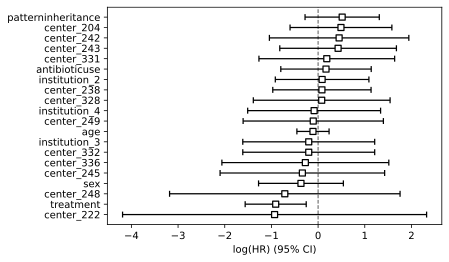

In [48]:
cph2.plot()
plt.show()

In [49]:
cph2_train = cph2.score(df_train, scoring_method='concordance_index')
cph2_test = cph2.score(df_test, scoring_method='concordance_index')

In [50]:
print('CPH Model w/o Weight and Height')
print('Training Score: ', cph2_train)
print('Testing Score: ', cph2_test)

CPH Model w/o Weight and Height
Training Score:  0.7147591692443659
Testing Score:  0.5298804780876494


In [51]:
df_train.columns

Index(['treatment', 'sex', 'age', 'heightcm', 'weightkg', 'patterninheritance',
       'corticosteroiduse', 'antibioticuse', 'infection', 'time', 'center_174',
       'center_204', 'center_222', 'center_238', 'center_242', 'center_243',
       'center_245', 'center_248', 'center_249', 'center_328', 'center_331',
       'center_332', 'center_336', 'institution_1', 'institution_2',
       'institution_3', 'institution_4'],
      dtype='object')

In [52]:
#Drop center and institution
columns = ['time', 'infection','treatment', 'sex', 'age', 'patterninheritance']
#columns = ['time', 'infection','treatment', 'sex', 'age']

cph3 = CoxPHFitter(penalizer=0.01)
cph3.fit(df_train[columns], duration_col='time', event_col='infection')

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>

In [53]:
cph3.check_assumptions(df_train[columns])

Proportional hazard assumption looks okay.


In [54]:
cph3.print_summary()

<lifelines.CoxPHFitter: fitted with 96 total observations, 62 right-censored observations>
             duration col = 'time'
                event col = 'infection'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 96
number of events observed = 34
   partial log-likelihood = -131.89
         time fit was run = 2020-12-13 02:32:04 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                  
treatment           -1.15       0.32       0.39            -1.91            -0.39                 0.15                 0.68
sex                 -0.39       0.68       0.53            -1.42             0.65                 0.24                 1.91
age                 -0.24       0.79       0.17            -0.57             0.10                 0.56                 1.10
patterninheritance   0.65       1.92       0.45            -0.23             1.54                 0.79                 4.65
                       z      p   -log2(p)
covariate                                 
treatment          -2.95 <0.005       8.32
sex                -0.73   0.46       1.11
age                -1.38   0.17       2.58
patterninheritance  1.45   0.15       2.76
---
Concordance = 0.67
Partial AIC = 271.78
log-likelihood ratio test = 13.86 on 4 df
-log2(p) of ll-ratio test = 7.01

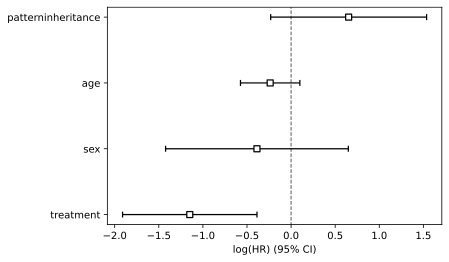

In [55]:
cph3.plot()
plt.show()

In [56]:
cph3_train = cph3.score(df_train, scoring_method='concordance_index')
cph3_test = cph3.score(df_test, scoring_method='concordance_index')

In [57]:
print('CPH Model w/o x Features')
print('Training Score: ', cph3_train)
print('Testing Score: ', cph3_test)

CPH Model w/o x Features
Training Score:  0.6730004418912947
Testing Score:  0.5856573705179283


Based on the AICs of each of the CPH models, the last model is determined to be the best fit because it has the lowest AIC. We could also perform the likelihood ratio tests to confirm that it is safe to drop particular variables from the model.

The chosen model (third CPH model) contains the covariates 'time', 'infection','treatment', 'sex', 'age', and 'patterninheritance'. The hazard ratio for the treatment group is 0.29 with a 95% CI (0.15, 0.68) and the reduction is statistically significant (Wald Test: p<0.005). We can interpret this hazard ratio as the hazard for infection is reduced by 71% with interferon gamma treatment compared to placebo. 

### Random Survival Forests

Introducing machine learning methods to survival analysis has helped solve some issues with traditional survival models. Survival trees is advantageous in that it can model non-linear relationships. Cox Proportional Hazards model assumes the shape of the risk is the same in all patients, different only in the proportions. On the other hand, survival trees captures the non-linearities between patients where risk factor hazards can change and switch over time.

Paper: https://arxiv.org/pdf/0811.1645.pdf

In [58]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.util import Surv

In [59]:
df = pd.read_stata('gi_gcd.dta')

infection = []
for value in df.iloc[:, -7:].sum(axis=1):
    if value != 0.0:
        infection.append(1)
    else:
        infection.append(0)

df['infection'] = infection
df['time'] = df.apply(lambda x: time_gen(x), axis=1)

df['weightkg'] = np.log(df['weightkg'])
df.drop(['id', 'randomisationdate', 'timetofollowup', 'time1','time2','time3',
         'time4','time5','time6','time7'], axis=1, inplace=True)

#Re-encode 1/2 to 0/1
df['sex'] = df['sex'].apply(lambda x: 0 if x==1 else 1)
df['patterninheritance'] = df['patterninheritance'].apply(lambda x: 0 if x==1 else 1)
df['corticosteroiduse'] = df['corticosteroiduse'].apply(lambda x: 0 if x==1 else 1)
df['antibioticuse'] = df['antibioticuse'].apply(lambda x: 0 if x==1 else 1)

In [60]:
df.columns

Index(['center', 'treatment', 'sex', 'age', 'heightcm', 'weightkg',
       'patterninheritance', 'corticosteroiduse', 'antibioticuse',
       'institution', 'infection', 'time'],
      dtype='object')

In [61]:
columns = ['time', 'infection','treatment', 'sex', 'age']

df= df[columns]

In [62]:
np.random.seed(random_seed)
df_train, df_test = train_test_split(df, test_size = 0.20)

X_train = df_train.drop(['time','infection'], axis=1)
y_train = Surv.from_arrays(df_train['infection'], df_train['time'])

X_test = df_test.drop(['time','infection'], axis=1)
y_test = Surv.from_arrays(df_test['infection'], df_test['time'])

In [63]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=20)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(2, 10, num=10)]
min_samples_split = [2,3,5,7,9,11]
min_samples_leaf = [2,3,4,5,6,7]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }

rsf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(estimator= rsf, 
                               param_distributions= param_grid,
                               n_iter=100,
                               cv=5,
                               verbose=2, 
                               n_jobs = -1)

rf_random.fit(X_train, y_train,)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, estimator=RandomSurvivalForest(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7],
                                        'min_samples_split': [2, 3, 5, 7, 9,
                                                              11],
                                        'n_estimators': [100, 147, 194, 242,
                                                         289, 336, 384, 431,
                                                         478, 526, 573, 621,
                                                         668, 715, 763, 810,
                                                         857, 905, 952, 1000]},
                   verbose=2)

In [64]:
rf_random.best_params_

{'n_estimators': 336,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 2}

In [65]:
rsf = RandomSurvivalForest(**rf_random.best_params_)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_depth=2, min_samples_leaf=2, min_samples_split=5,
                     n_estimators=336)

In [66]:
rsf_train = rsf.score(X_train, y_train)
rsf_test = rsf.score(X_test, y_test)

In [67]:
print("Random Survival Forest Model")
print("Training Score: ", rsf_train)
print("Testing Score: ", rsf_test)

Random Survival Forest Model
Training Score:  0.696917808219178
Testing Score:  0.6644295302013423


In [68]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

Weight,Feature
0.1018 ± 0.1759,treatment
0.0508 ± 0.1150,age
-0.0096 ± 0.0981,sex


* The permutation importance suggests the treatment of interferon gamma had the most impact in survivability

### Survival SVM

In [69]:
df = pd.read_stata('gi_gcd.dta')

infection = []
for value in df.iloc[:, -7:].sum(axis=1):
    if value != 0.0:
        infection.append(1)
    else:
        infection.append(0)

df['infection'] = infection
df['time'] = df.apply(lambda x: time_gen(x), axis=1)

df['weightkg'] = np.log(df['weightkg'])
df.drop(['id', 'randomisationdate', 'timetofollowup', 'time1','time2','time3',
         'time4','time5','time6','time7'], axis=1, inplace=True)

#Re-encode 1/2 to 0/1
df['sex'] = df['sex'].apply(lambda x: 0 if x==1 else 1)
df['patterninheritance'] = df['patterninheritance'].apply(lambda x: 0 if x==1 else 1)
df['corticosteroiduse'] = df['corticosteroiduse'].apply(lambda x: 0 if x==1 else 1)
df['antibioticuse'] = df['antibioticuse'].apply(lambda x: 0 if x==1 else 1)

#Dummy Encode Categorical Variables
cat_columns = ['center', 'institution']
onehot_df = pd.get_dummies(df, columns= cat_columns, drop_first=True)

In [70]:
columns = ['time', 'infection','treatment', 'sex', 'age']

df = onehot_df[columns]

In [71]:
np.random.seed(random_seed)
df_train, df_test = train_test_split(df, test_size = 0.20)

X_train = df_train.drop(['time','infection'], axis=1)
y_train = Surv.from_arrays(df_train['infection'], df_train['time'])

X_test = df_test.drop(['time','infection'], axis=1)
y_test = Surv.from_arrays(df_test['infection'], df_test['time'])

#Normalization
#continuous_columns = ['age', 'heightcm', 'weightkg']
continuous_columns = ['age']
train_mean = df_train.loc[:, continuous_columns].mean()
train_std = df_train.loc[:, continuous_columns].std()

df_train.loc[:, continuous_columns] = (df_train.loc[:, continuous_columns] - train_mean) / train_std
df_test.loc[:, continuous_columns] = (df_test.loc[:, continuous_columns] - train_mean) / train_std

In [72]:
random_grid = {'optimizer': ['rbtree','simple','avltree'],
               'fit_intercept': [True,False],
               'max_iter': [int(x) for x in np.linspace(start=20, stop=60, num =20)],
               'alpha': [1,2,3,4,5,6,7,8,9,10],
               'tol':[1e-5,1e-6, 1e-7]
              }

fastsvm = FastSurvivalSVM()

fastsvm_random = RandomizedSearchCV(estimator = fastsvm, 
                               param_distributions = random_grid,
                               n_iter=100,
                               verbose=2, 
                               n_jobs = -1)

fastsvm_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 485 out of 500 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


RandomizedSearchCV(estimator=FastSurvivalSVM(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                  10],
                                        'fit_intercept': [True, False],
                                        'max_iter': [20, 22, 24, 26, 28, 30, 32,
                                                     34, 36, 38, 41, 43, 45, 47,
                                                     49, 51, 53, 55, 57, 60],
                                        'optimizer': ['rbtree', 'simple',
                                                      'avltree'],
                                        'tol': [1e-05, 1e-06, 1e-07]},
                   verbose=2)

In [73]:
fastsvm = FastSurvivalSVM(**fastsvm_random.best_params_)
fastsvm.fit(X_train, y_train)

FastSurvivalSVM(alpha=5, max_iter=53, optimizer='rbtree', tol=1e-07)

In [74]:
svm_train = fastsvm.score(X_train, y_train)
svm_test = fastsvm.score(X_test, y_test)

In [75]:
print("Fast Survival SVM Model")
print("Training Score: ", svm_train)
print("Testing Score: ", svm_test)

Fast Survival SVM Model
Training Score:  0.6603881278538812
Testing Score:  0.6577181208053692


### Model Comparisons

In [76]:
print('Full CPH Model')
print('Training Score: ', cph_train)
print('Testing Score: ', cph_test)
print('====================================')

print('CPH Model w/o Weight and Height')
print('Training Score: ', cph2_train)
print('Testing Score: ', cph2_test)
print('====================================')

print('CPH Model w/o x Features')
print('Training Score: ', cph3_train)
print('Testing Score: ', cph3_test)
print('====================================')

print("Random Survival Forest Model")
print("Training Score: ", rsf_train)
print("Testing Score: ", rsf_test)
print('====================================')

print("Fast Survival SVM Model")
print("Training Score: ", svm_train)
print("Testing Score: ", svm_test)

Full CPH Model
Training Score:  0.7414935925762263
Testing Score:  0.6215139442231076
CPH Model w/o Weight and Height
Training Score:  0.7147591692443659
Testing Score:  0.5298804780876494
CPH Model w/o x Features
Training Score:  0.6730004418912947
Testing Score:  0.5856573705179283
Random Survival Forest Model
Training Score:  0.696917808219178
Testing Score:  0.6644295302013423
Fast Survival SVM Model
Training Score:  0.6603881278538812
Testing Score:  0.6577181208053692


### Predicting Survival Curves for New Observations (Patients)
Using our survival models, we can produce survival curves for patients given their covariates. This is useful for clinicians to diagnose the severity of a patient's condition with a particular disease. Using the survival models to predict the survival probabilities, clinicians can strategize a treatment plan for patients.

Let's compare two males that are both 18 years old but one is given the treatment while the other receives placebo. If our model works, we should expect to see the the survival probability to be higher in the patient receiving the treatment.

Survival probabilities over time: 
 [0.98943489 0.97184916 0.9514731  0.9321771  0.922642   0.9134908
 0.89618761 0.89010074 0.88338918 0.87338    0.866813   0.84540155
 0.83995303 0.83788564 0.83174114 0.81289532 0.80586319 0.8004647
 0.78866902 0.78743496 0.77788238 0.77103266 0.76085346 0.75849167
 0.74542105 0.73734253 0.71300374 0.70508843 0.70156335 0.69136871
 0.66136199 0.62301309 0.58220969 0.53543571 0.46899316 0.39591809
 0.34329863]


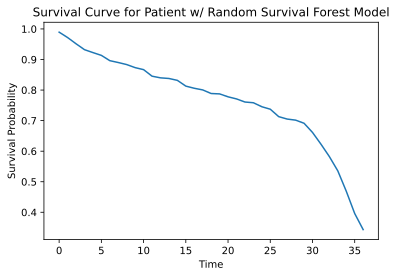

In [77]:
new_obs = {'treatment': [0], 'sex': [0], 'age': [18]}
pd.DataFrame.from_dict(new_obs)

observation = pd.DataFrame.from_dict(new_obs)
prediction = rsf.predict_survival_function(observation)[0]
print('Survival probabilities over time: \n', prediction)
plt.plot(np.arange(len(prediction)), prediction)
plt.title('Survival Curve for Patient w/ Random Survival Forest Model')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

Survival probabilities over time: 
 [0.99782496 0.99247558 0.98490127 0.97815318 0.97721285 0.97569182
 0.97024022 0.96811682 0.950634   0.94860895 0.93008035 0.92288033
 0.92154684 0.90863869 0.90697497 0.90055792 0.88182706 0.86490344
 0.86230257 0.8554358  0.85385544 0.83390152 0.8327289  0.8223999
 0.81920609 0.81759868 0.81009929 0.78812645 0.77119484 0.74093456
 0.73225311 0.72096657 0.70923315 0.6954821  0.67967743 0.65875441
 0.51933548]


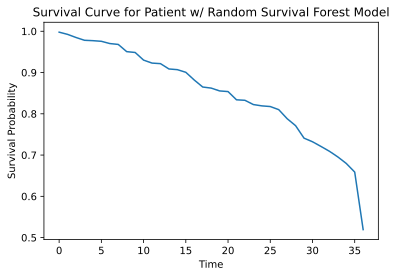

In [78]:
new_obs = {'treatment': [1], 'sex': [0], 'age': [18]}
pd.DataFrame.from_dict(new_obs)

observation = pd.DataFrame.from_dict(new_obs)
prediction = rsf.predict_survival_function(observation)[0]
print('Survival probabilities over time: \n', prediction)
plt.plot(np.arange(len(prediction)), prediction)
plt.title('Survival Curve for Patient w/ Random Survival Forest Model')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

The 18 year old male patient receiving the treatment does in fact have a higher survival probability than the 18 year old male receiving the placebo. This means our survival model should be working correctly given our survival analysis. 